### Задание 1: 
Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [13]:
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [7]:
def bias(y, z):
    return (y - z)

Немного изменим код из методички, потому что на выходе нам не нужны оценки ошибок по всем итерациям деревьев, а нужна общая оценка по модели

In [23]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_error = float()
    test_error = float()
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))

        trees.append(tree)
    
    train_error = mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta))
    test_error = mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta))
        
    return trees, train_error, test_error

Создадим функию для обучения модели и отрисовки графика по настраиваемым гиперпараметрам

In [58]:
def estimate_gradient_boost(data: list, coefs=1, eta=1, n_trees=10, max_depth=3):
    
    if n_trees == "estimate":
        train_errors = []
        test_errors = []
        for i in range(0, 200, 25):
            coefs = [coefs for coefs in range(i)]
            trees, train, test = gb_fit(i, max_depth, data[0], data[1], data[2], data[3], coefs, eta)
            train_errors.append(train)
            test_errors.append(test)
        
        plt.xlabel('Trees number')
        plt.ylabel('MSE')
        plt.xlim(0, 100)
        plt.plot(list(range(0, 200, 25)), train_errors, label='train error')
        plt.plot(list(range(0, 200, 25)), test_errors, label='test error')
        plt.legend(loc='upper right')
        plt.show()
    
    elif max_depth == "estimate":
        coefs = [coefs] * n_trees
        train_errors = []
        test_errors = []
        for i in range(1, 16):
            trees, train, test = gb_fit(n_trees, i, data[0], data[1], data[2], data[3], coefs, eta)
            train_errors.append(train)
            test_errors.append(test)
        
        plt.xlabel('Max depth of trees')
        plt.ylabel('MSE')
        plt.xlim(1, 16)
        plt.plot(list(range(1, 16)), train_errors, label='train error')
        plt.plot(list(range(1, 16)), test_errors, label='test error')
        plt.legend(loc='upper right')
        plt.show()
        
    else:
        trees, train, test = gb_fit(n_trees, max_depth, data[0], data[1], data[2], data[3], coefs, eta)
        return trees, train, test

In [35]:
data = [X_train, X_test, y_train, y_test]

In [ ]:
estimate_gradient_boost(data, coefs=1, eta=0.1, n_trees="estimate", max_depth=3)

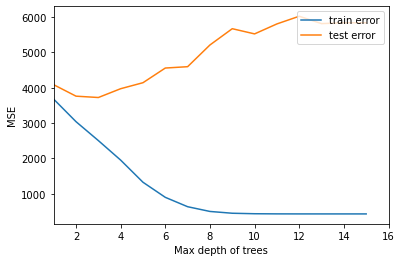

In [52]:
estimate_gradient_boost(data, coefs=1, eta=0.1, n_trees=20, max_depth="estimate")

Как видно из графика уеличение глубины деревьев приводит к увеличению переобучения. Судя по графику на этих данных оптимальным будет уровень глубины дерева 3